# Image Classification on CIFAR-100

### Imports

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
import pandas as pd
import os

### Custom models and optimizers

In [ ]:
from models import BiggerConvNN     # defined in models.py
from new_optimizers import MomentumSGD_Strong_Wolfe, Adam_Strong_Wolfe, TrustRegionCauchy   # defined in new_optimizers.py

### Downloading the dataset and normalizing

In [3]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,)) # mean and std for MNIST
])

train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

### Preparing PyTorch dataLoaders

In [4]:
torch.manual_seed(42)
train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=1000, shuffle=False)

### Defining train and test functions

In [5]:
criterion = nn.CrossEntropyLoss()

def train(model, device, train_loader, optimizer, epoch, lm=False):
    model.train()
    avg_loss = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        
        def closure(backward=True):
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            if backward:
                loss.backward() # backward computes the gradients, stores them in the parameters, and deletes the computation graph
            return loss
        
        loss = closure()
        optimizer.step(closure)
        
        if batch_idx % 100 == 0:
            print(f'Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)}'
                  f' ({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}')

        avg_loss += loss.item()
    
    avg_loss /= len(train_loader)
    return avg_loss
        
def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    print(f'\nTest set: Average loss: {test_loss:.4f}, Accuracy: {correct}/{len(test_loader.dataset)}'
          f' ({100. * correct / len(test_loader.dataset):.0f}%)\n')
    return test_loss, correct / len(test_loader.dataset)

### Preparing data

In [32]:
# download CIFAR-100
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5071, 0.4865, 0.4409), (0.2673, 0.2564, 0.2762)) # mean and std for CIFAR-100
])
cifar100_train = datasets.CIFAR100(root='./data', train=True, download=True, transform=transform)
cifar100_test = datasets.CIFAR100(root='./data', train=False, download=True, transform=transform)

Files already downloaded and verified
Files already downloaded and verified


In [33]:
torch.manual_seed(42)
train_loader_cifar = DataLoader(dataset=cifar100_train, batch_size=64, shuffle=True)
test_loader_cifar = DataLoader(dataset=cifar100_test, batch_size=1000, shuffle=False)

### Model training with the optimziers

In [ ]:
epochs = 5

all_train_loss = []
all_test_loss = []
all_test_acc = []

In [35]:
# Benchmark 1: SGD with Momentum
print("Benchmark 1: SGD with Momentum")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = BiggerConvNN().to(device)
optimizer1 = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

train_loss_over_epochs = []
test_loss_over_epochs = []
test_acc_over_epochs = []
for epoch in range(1, epochs + 1):
    avg_loss = train(model, device, train_loader_cifar, optimizer1, epoch)
    train_loss_over_epochs.append(avg_loss)
    test_loss, test_acc = test(model, device, test_loader_cifar)
    test_loss_over_epochs.append(test_loss)
    test_acc_over_epochs.append(test_acc)

all_train_loss.append(train_loss_over_epochs)
all_test_loss.append(test_loss_over_epochs)
all_test_acc.append(test_acc_over_epochs)

Benchmark 1: SGD with Momentum
Train Epoch: 1 [0/50000 (0%)]	Loss: 4.603092
Train Epoch: 1 [6400/50000 (13%)]	Loss: 4.563788
Train Epoch: 1 [12800/50000 (26%)]	Loss: 4.100669
Train Epoch: 1 [19200/50000 (38%)]	Loss: 3.895453
Train Epoch: 1 [25600/50000 (51%)]	Loss: 3.872535
Train Epoch: 1 [32000/50000 (64%)]	Loss: 3.591958
Train Epoch: 1 [38400/50000 (77%)]	Loss: 3.497224
Train Epoch: 1 [44800/50000 (90%)]	Loss: 3.634856

Test set: Average loss: 0.0033, Accuracy: 2080/10000 (21%)

Train Epoch: 2 [0/50000 (0%)]	Loss: 3.156208
Train Epoch: 2 [6400/50000 (13%)]	Loss: 3.243623
Train Epoch: 2 [12800/50000 (26%)]	Loss: 3.029223
Train Epoch: 2 [19200/50000 (38%)]	Loss: 2.693269
Train Epoch: 2 [25600/50000 (51%)]	Loss: 3.110548
Train Epoch: 2 [32000/50000 (64%)]	Loss: 3.221913
Train Epoch: 2 [38400/50000 (77%)]	Loss: 2.615212
Train Epoch: 2 [44800/50000 (90%)]	Loss: 2.810373

Test set: Average loss: 0.0029, Accuracy: 2769/10000 (28%)

Train Epoch: 3 [0/50000 (0%)]	Loss: 2.681666
Train Epoch: 3

In [36]:
# Benchmark 2: Adam
print("Benchmark 2: Adam")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = BiggerConvNN().to(device)
optimizer2 = torch.optim.Adam(model.parameters(), lr=0.001)

train_loss_over_epochs = []
test_loss_over_epochs = []
test_acc_over_epochs = []
for epoch in range(1, epochs + 1):
    avg_loss = train(model, device, train_loader_cifar, optimizer2, epoch)
    train_loss_over_epochs.append(avg_loss)
    test_loss, test_acc = test(model, device, test_loader_cifar)
    test_loss_over_epochs.append(test_loss)
    test_acc_over_epochs.append(test_acc)

all_train_loss.append(train_loss_over_epochs)
all_test_loss.append(test_loss_over_epochs)
all_test_acc.append(test_acc_over_epochs)

Benchmark 2: Adam
Train Epoch: 1 [0/50000 (0%)]	Loss: 4.601539
Train Epoch: 1 [6400/50000 (13%)]	Loss: 4.108176
Train Epoch: 1 [12800/50000 (26%)]	Loss: 3.695310
Train Epoch: 1 [19200/50000 (38%)]	Loss: 3.418226
Train Epoch: 1 [25600/50000 (51%)]	Loss: 3.451406
Train Epoch: 1 [32000/50000 (64%)]	Loss: 3.331420
Train Epoch: 1 [38400/50000 (77%)]	Loss: 2.973582
Train Epoch: 1 [44800/50000 (90%)]	Loss: 3.396677

Test set: Average loss: 0.0029, Accuracy: 2738/10000 (27%)

Train Epoch: 2 [0/50000 (0%)]	Loss: 2.943355
Train Epoch: 2 [6400/50000 (13%)]	Loss: 2.667480
Train Epoch: 2 [12800/50000 (26%)]	Loss: 2.830215
Train Epoch: 2 [19200/50000 (38%)]	Loss: 2.715247
Train Epoch: 2 [25600/50000 (51%)]	Loss: 2.642733
Train Epoch: 2 [32000/50000 (64%)]	Loss: 2.332491
Train Epoch: 2 [38400/50000 (77%)]	Loss: 2.689538
Train Epoch: 2 [44800/50000 (90%)]	Loss: 2.482281

Test set: Average loss: 0.0026, Accuracy: 3549/10000 (35%)

Train Epoch: 3 [0/50000 (0%)]	Loss: 2.244505
Train Epoch: 3 [6400/50000 

In [37]:
# New Optimizer 1: MomentumSGD_Strong_Wolfe
print("New Optimizer 1: MomentumSGD_Strong_Wolfe")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = BiggerConvNN().to(device)
optimizer3 = MomentumSGD_Strong_Wolfe(model.parameters(), alpha1=0.01)

train_loss_over_epochs = []
test_loss_over_epochs = []
test_acc_over_epochs = []
for epoch in range(1, epochs + 1):
    avg_loss = train(model, device, train_loader_cifar, optimizer3, epoch)
    train_loss_over_epochs.append(avg_loss)
    test_loss, test_acc = test(model, device, test_loader_cifar)
    test_loss_over_epochs.append(test_loss)
    test_acc_over_epochs.append(test_acc)

all_train_loss.append(train_loss_over_epochs)
all_test_loss.append(test_loss_over_epochs)
all_test_acc.append(test_acc_over_epochs)

New Optimizer 1: MomentumSGD_Strong_Wolfe
Train Epoch: 1 [0/50000 (0%)]	Loss: 4.605587
Train Epoch: 1 [6400/50000 (13%)]	Loss: 4.055898
Train Epoch: 1 [12800/50000 (26%)]	Loss: 4.280821
Train Epoch: 1 [19200/50000 (38%)]	Loss: 3.995561
Train Epoch: 1 [25600/50000 (51%)]	Loss: 3.602781
Train Epoch: 1 [32000/50000 (64%)]	Loss: 3.837527
Train Epoch: 1 [38400/50000 (77%)]	Loss: 3.263014
Train Epoch: 1 [44800/50000 (90%)]	Loss: 3.473063

Test set: Average loss: 0.0031, Accuracy: 2380/10000 (24%)

Train Epoch: 2 [0/50000 (0%)]	Loss: 3.096529
Train Epoch: 2 [6400/50000 (13%)]	Loss: 2.956773
Train Epoch: 2 [12800/50000 (26%)]	Loss: 3.063658
Train Epoch: 2 [19200/50000 (38%)]	Loss: 3.018014
Train Epoch: 2 [25600/50000 (51%)]	Loss: 2.753203
Train Epoch: 2 [32000/50000 (64%)]	Loss: 2.620518
Train Epoch: 2 [38400/50000 (77%)]	Loss: 2.868355
Train Epoch: 2 [44800/50000 (90%)]	Loss: 2.635892

Test set: Average loss: 0.0027, Accuracy: 3155/10000 (32%)

Train Epoch: 3 [0/50000 (0%)]	Loss: 2.656312
Tra

In [38]:
# New Optimizer 2: Adam_Strong_Wolfe
print("New Optimizer 2: Adam_Strong_Wolfe")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = BiggerConvNN().to(device)
optimizer4 = Adam_Strong_Wolfe(model.parameters(), alpha1=0.01, betas=(0.9, 0.999))

train_loss_over_epochs = []
test_loss_over_epochs = []
test_acc_over_epochs = []
for epoch in range(1, epochs + 1):
    avg_loss = train(model, device, train_loader_cifar, optimizer4, epoch)
    train_loss_over_epochs.append(avg_loss)
    test_loss, test_acc = test(model, device, test_loader_cifar)
    test_loss_over_epochs.append(test_loss)
    test_acc_over_epochs.append(test_acc)

all_train_loss.append(train_loss_over_epochs)
all_test_loss.append(test_loss_over_epochs)
all_test_acc.append(test_acc_over_epochs)

New Optimizer 2: Adam_Strong_Wolfe
Train Epoch: 1 [0/50000 (0%)]	Loss: 4.610569
Train Epoch: 1 [6400/50000 (13%)]	Loss: 3.960821
Train Epoch: 1 [12800/50000 (26%)]	Loss: 3.667587
Train Epoch: 1 [19200/50000 (38%)]	Loss: 3.721322
Train Epoch: 1 [25600/50000 (51%)]	Loss: 3.222768
Train Epoch: 1 [32000/50000 (64%)]	Loss: 3.123799
Train Epoch: 1 [38400/50000 (77%)]	Loss: 3.255210
Train Epoch: 1 [44800/50000 (90%)]	Loss: 3.012447

Test set: Average loss: 0.0028, Accuracy: 2941/10000 (29%)

Train Epoch: 2 [0/50000 (0%)]	Loss: 3.111982
Train Epoch: 2 [6400/50000 (13%)]	Loss: 2.504074
Train Epoch: 2 [12800/50000 (26%)]	Loss: 2.895402
Train Epoch: 2 [19200/50000 (38%)]	Loss: 2.388878
Train Epoch: 2 [25600/50000 (51%)]	Loss: 2.593738
Train Epoch: 2 [32000/50000 (64%)]	Loss: 2.550179
Train Epoch: 2 [38400/50000 (77%)]	Loss: 2.725822
Train Epoch: 2 [44800/50000 (90%)]	Loss: 2.195760

Test set: Average loss: 0.0024, Accuracy: 3782/10000 (38%)

Train Epoch: 3 [0/50000 (0%)]	Loss: 1.908601
Train Epoc

In [39]:
# New Optimizer 3: TrustRegionCauchy
print("New Optimizer 3: TrustRegionCauchy")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = BiggerConvNN().to(device)
optimizer5 = TrustRegionCauchy(model.parameters())

train_loss_over_epochs = []
test_loss_over_epochs = []
test_acc_over_epochs = []
for epoch in range(1, epochs + 1):
    avg_loss = train(model, device, train_loader_cifar, optimizer5, epoch)
    train_loss_over_epochs.append(avg_loss)
    test_loss, test_acc = test(model, device, test_loader_cifar)
    test_loss_over_epochs.append(test_loss)
    test_acc_over_epochs.append(test_acc)

all_train_loss.append(train_loss_over_epochs)
all_test_loss.append(test_loss_over_epochs)
all_test_acc.append(test_acc_over_epochs)

New Optimizer 3: TrustRegionCauchy
Train Epoch: 1 [0/50000 (0%)]	Loss: 4.609703
Train Epoch: 1 [6400/50000 (13%)]	Loss: 4.420891
Train Epoch: 1 [12800/50000 (26%)]	Loss: 6.016856
Train Epoch: 1 [19200/50000 (38%)]	Loss: 4.009916
Train Epoch: 1 [25600/50000 (51%)]	Loss: 4.041830
Train Epoch: 1 [32000/50000 (64%)]	Loss: 4.281322
Train Epoch: 1 [38400/50000 (77%)]	Loss: 3.950269
Train Epoch: 1 [44800/50000 (90%)]	Loss: 4.017386

Test set: Average loss: 0.0038, Accuracy: 1076/10000 (11%)

Train Epoch: 2 [0/50000 (0%)]	Loss: 3.952935
Train Epoch: 2 [6400/50000 (13%)]	Loss: 4.153876
Train Epoch: 2 [12800/50000 (26%)]	Loss: 3.406990
Train Epoch: 2 [19200/50000 (38%)]	Loss: 3.839308
Train Epoch: 2 [25600/50000 (51%)]	Loss: 4.220530
Train Epoch: 2 [32000/50000 (64%)]	Loss: 3.317172
Train Epoch: 2 [38400/50000 (77%)]	Loss: 3.324986
Train Epoch: 2 [44800/50000 (90%)]	Loss: 3.351195

Test set: Average loss: 0.0032, Accuracy: 2145/10000 (21%)

Train Epoch: 3 [0/50000 (0%)]	Loss: 3.145941
Train Epoc

In [41]:
# save results to csv
os.makedirs("CIFAR100_results", exist_ok=True)
pd.DataFrame(all_train_loss).to_csv('CIFAR100_results/train_loss.csv', index=False)
pd.DataFrame(all_test_loss).to_csv('CIFAR100_results/test_loss.csv', index=False)
pd.DataFrame(all_test_acc).to_csv('CIFAR100_results/test_accuracy.csv', index=False)

In [ ]:
# load results if already saved
# all_train_loss = pd.read_csv('CIFAR100_results/train_loss.csv').values
# all_test_loss = pd.read_csv('CIFAR100_results/test_loss.csv').values
# all_test_acc = pd.read_csv('CIFAR100_results/test_accuracy.csv').values

### Plotting results

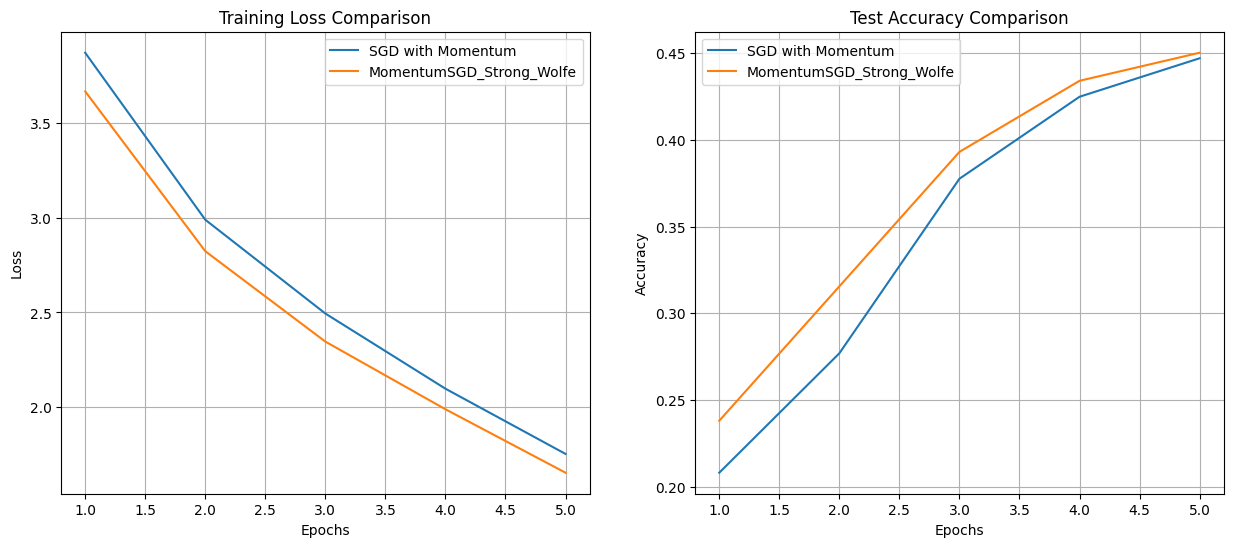

In [51]:
# Plotting MomentumSGD vs MomentumSGD_Strong_Wolfe
plt.figure(figsize=(15, 6))
x = range(1, epochs + 1)

plt.subplot(1, 2, 1)
plt.plot(x, all_train_loss[0], label='SGD with Momentum')
plt.plot(x, all_train_loss[2], label='MomentumSGD_Strong_Wolfe')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Comparison')
plt.legend()
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(x, all_test_acc[0], label='SGD with Momentum')
plt.plot(x, all_test_acc[2], label='MomentumSGD_Strong_Wolfe')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Test Accuracy Comparison')
plt.legend()
plt.grid()

plt.show()

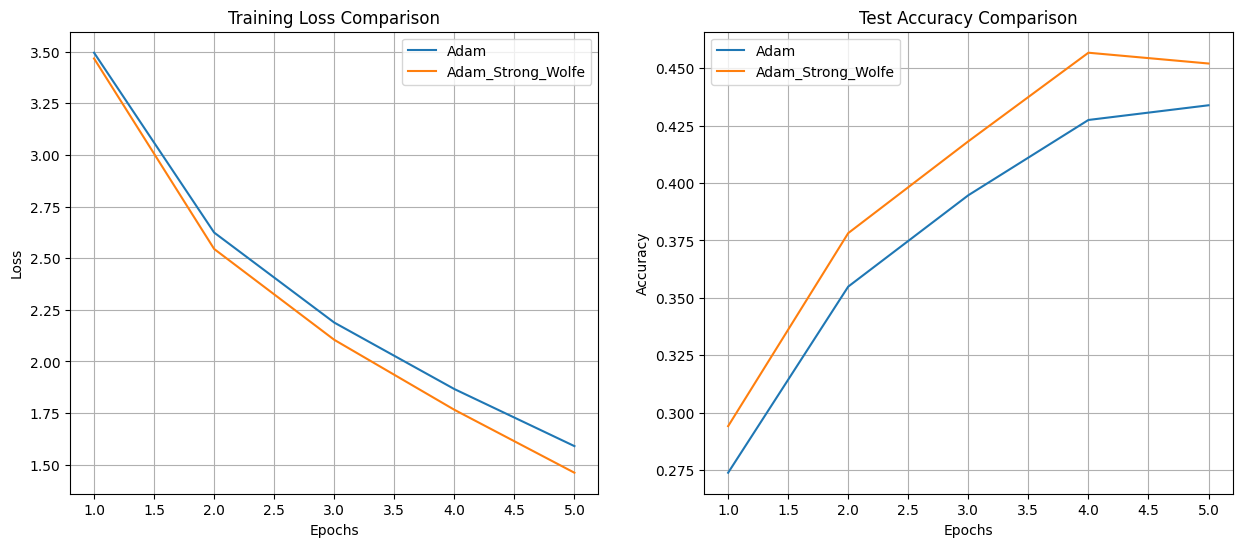

In [52]:
# Plotting Adam vs Adam_Strong_Wolfe
plt.figure(figsize=(15, 6))
x = range(1, epochs + 1)

plt.subplot(1, 2, 1)
plt.plot(x, all_train_loss[1], label='Adam')
plt.plot(x, all_train_loss[3], label='Adam_Strong_Wolfe')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Comparison')
plt.legend()
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(x, all_test_acc[1], label='Adam')
plt.plot(x, all_test_acc[3], label='Adam_Strong_Wolfe')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Test Accuracy Comparison')
plt.legend()
plt.grid()

plt.show()

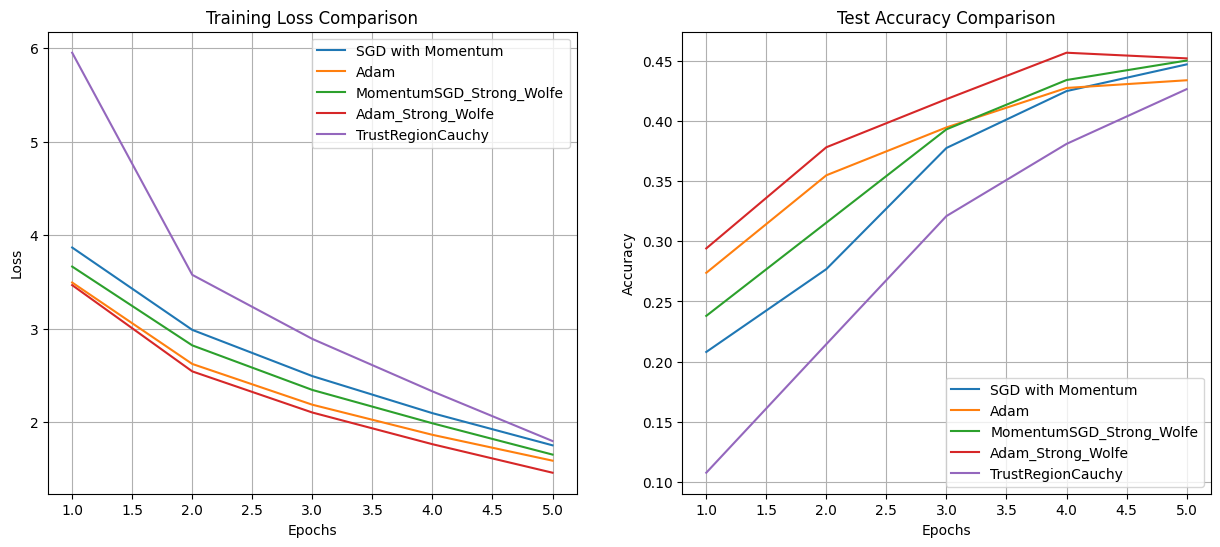

In [53]:
# Plotting all train loss and test accuracy
plt.figure(figsize=(15, 6))
x = range(1, epochs + 1)
plt.subplot(1, 2, 1)
for i, label in enumerate(['SGD with Momentum', 'Adam', 'MomentumSGD_Strong_Wolfe', 'Adam_Strong_Wolfe', 'TrustRegionCauchy']):
    plt.plot(x, all_train_loss[i], label=f'{label}')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Comparison')
plt.legend()
plt.grid()

plt.subplot(1, 2, 2)
for i, label in enumerate(['SGD with Momentum', 'Adam', 'MomentumSGD_Strong_Wolfe', 'Adam_Strong_Wolfe', 'TrustRegionCauchy']):
    plt.plot(x, all_test_acc[i], label=f'{label}')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Test Accuracy Comparison')
plt.legend()
plt.grid()

plt.show()